# CountMatch Integration Testing

This tests the end-to-end pipeline of CountMatch acting on FLOW data.  We're testing for:

- Whether the code (both Standard and Bagheri variants) run properly.
- The typical time it takes to run one year of data.
- Whether the data make sense or not.

In [1]:
%matplotlib inline
import sys
sys.path.append('./bdit_traffic_prophet/')
import importlib
import matplotlib.pyplot as plt
import numpy as np
import knowyourdata as kyd
import matplotlib.colors as colors

import folium

import psycopg2

import geopandas as gpd

import pandas as pd
from traffic_prophet import cfg
import pathlib, os
import configparser

from traffic_prophet import connection

defaultcolours = plt.rcParams['axes.prop_cycle'].by_key()['color']

filepath = pathlib.Path.home().joinpath('.charlesconfig')
if os.path.isfile(filepath):
    vol_conn = connection.Connection(filepath, 'POSTGRES',
                                     'czhu.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'POSTGRES',
                                    'czhu.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['MAPBOX']['token']
    PLOTLY_USER = config['PLOTLY']['user']
    PLOTLY_KEY = config['PLOTLY']['key']
else:
    filepath = pathlib.Path.home().joinpath('cf.txt')
    vol_conn = connection.Connection(filepath, 'localpg',
                                     'prj_vol.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'localpg',
                                    'gis.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['mapbox']['token']
    PLOTLY_USER = config['plotly']['user']
    PLOTLY_KEY = config['plotly']['apikey']

cfg.cm['verbose'] = True

In [2]:
from traffic_prophet.countmatch import reader
from traffic_prophet.countmatch import permcount as pc
from traffic_prophet.countmatch import neighbour as nbr
import traffic_prophet.countmatch.matcher as mt

In [3]:
%%time
tcs = reader.read(vol_conn)

CPU times: user 1min 19s, sys: 306 ms, total: 1min 19s
Wall time: 1min 21s


In [4]:
%%time
pc.get_ptcs_sttcs(tcs)


CPU times: user 43.8 s, sys: 642 ms, total: 44.5 s
Wall time: 42.9 s


In [5]:
%%time
ptc_ids = np.unique(np.abs(list(tcs.ptcs.keys())))
nb = nbr.NeighbourLonLatEuclidean(ll_conn, 20, ptc_ids)
nb.find_neighbours()

CPU times: user 16.9 s, sys: 75.7 ms, total: 17 s
Wall time: 17 s


In [6]:
# Try a standard matcher first.
mb = mt.Matcher('Standard', tcs, nb)

In [7]:
# Test basic initialization crap.
assert mb.__class__ is mt.MatcherStandard
assert mb.nb is nb
assert mb._average_growth_factor is not None
assert mb._disable_tqdm is not cfg.cm['verbose']

In [8]:
%%time
results = mb.estimate_aadts(2016)


CPU times: user 9min 30s, sys: 9.3 s, total: 9min 40s
Wall time: 9min 24s


Highballing it, it takes around 15 minutes to make a single prediction.  Not bad!

In [9]:
combined_results = pd.concat([results[0], results[1]], axis=0, ignore_index=True)
combined_results['Centreline ID'] = abs(combined_results['Count ID'])

centreline_results = pd.DataFrame(
    combined_results.groupby('Centreline ID')['AADT Estimate'].mean()).reset_index()

centreline_results['Log AADT Estimate'] = np.round(
    np.log10(centreline_results['AADT Estimate'].values), decimals=2)
centreline_results['AADT Estimate'] = np.round(
    centreline_results['AADT Estimate'], decimals=2)

In [10]:
sql_query = """SELECT geo_id,
       geom
FROM gis.centreline;"""

with psycopg2.connect(database='bigdata', **vol_conn.credentials) as db_con:
    centreline_segments = gpd.read_postgis(sql_query, db_con)

centreline_segments = pd.merge(
    centreline_segments, centreline_results, left_on='geo_id',
    right_on='Centreline ID', how='inner')

centreline_segments.to_crs({'init': 'epsg:3347'}, inplace=True)

In [11]:
kyd.kyd(centreline_segments['Log AADT Estimate']);

| Basic Statistics                                          | Array Structure               	|
|                                                           |                               	|
|    Mean:         Min:   0.31        -99 CI:   1.76        | Number of Dimensions:   1     	|
|    3.454          1Q:   2.89        -95 CI:   2.12        | Shape of Dimensions:    (9973,)	|
|               Median:   3.54        -68 CI:   2.66        | Array Data Type:        float64	|
|   Std Dev:        3Q:   4.08        +68 CI:   4.18        | Memory Size:            78.0KiB	|
|    0.6967        Max:   5.03        +95 CI:   4.41        |                               	|
|                                     +99 CI:   4.8         | Number of NaN:  0             	|
|                                                           | Number of Inf:  0             	|

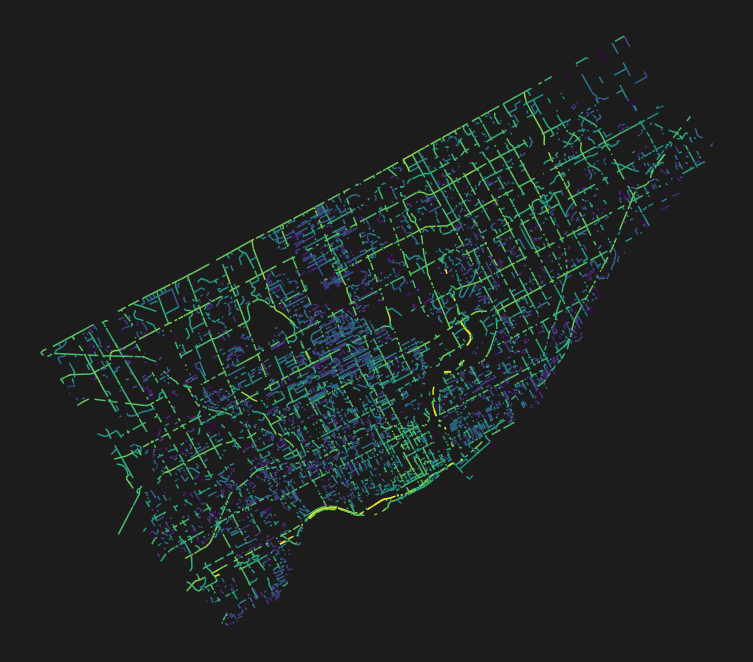

In [12]:
fig = plt.figure(figsize=(12, 9))
fig.patch.set_facecolor('#1c1c1c')
ax = fig.add_axes([0., 0., 1., 1.])
ax.axis('off')
centreline_segments.plot(
    column='AADT Estimate', ax=ax, cmap='viridis',
    norm=colors.LogNorm(), vmin=100., vmax=1e5)

[Text(0, 0.5, 'Number of Counts'), Text(0.5, 0, 'AADT')]

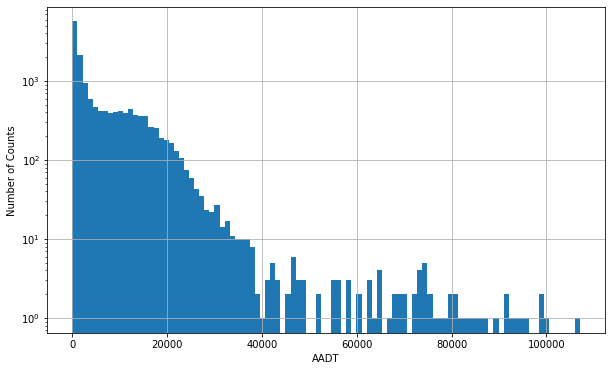

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
combined_results['AADT Estimate'].hist(
    ax=ax, bins=100, log=True)
ax.set(xlabel='AADT', ylabel='Number of Counts')

In [14]:
# from keplergl import KeplerGl 
# ctrmap = KeplerGl(height=750)
# ctrmap.add_data(centreline_segments[['Log AADT Estimate', 'AADT Estimate', 'geom']],
#                 name='AADT Data')
# ctrmap

In [15]:
tcsb = reader.read(vol_conn)
pc.get_ptcs_sttcs(tcsb)
nbb = nbr.NeighbourLonLatEuclidean(
    ll_conn, 20, np.unique(np.abs(list(tcsb.ptcs.keys()))))
nbb.find_neighbours()

In [16]:
mbb = mt.Matcher('Bagheri', tcsb, nbb)

In [17]:
results_bag = mbb.estimate_aadts(2016)

In [18]:
combined_results = pd.concat([results_bag[0], results_bag[1]], axis=0, ignore_index=True)
combined_results['Centreline ID'] = abs(combined_results['Count ID'])

centreline_results = pd.DataFrame(
    combined_results.groupby('Centreline ID')['AADT Estimate'].mean()).reset_index()

centreline_results['Log AADT Estimate'] = np.round(
    np.log10(centreline_results['AADT Estimate'].values), decimals=2)
centreline_results['AADT Estimate'] = np.round(
    centreline_results['AADT Estimate'], decimals=2)

In [19]:
sql_query = """SELECT geo_id,
       geom
FROM gis.centreline;"""

with psycopg2.connect(database='bigdata', **vol_conn.credentials) as db_con:
    centreline_segments = gpd.read_postgis(sql_query, db_con)

centreline_segments = pd.merge(
    centreline_segments, centreline_results, left_on='geo_id',
    right_on='Centreline ID', how='inner')

centreline_segments.to_crs({'init': 'epsg:3347'}, inplace=True)

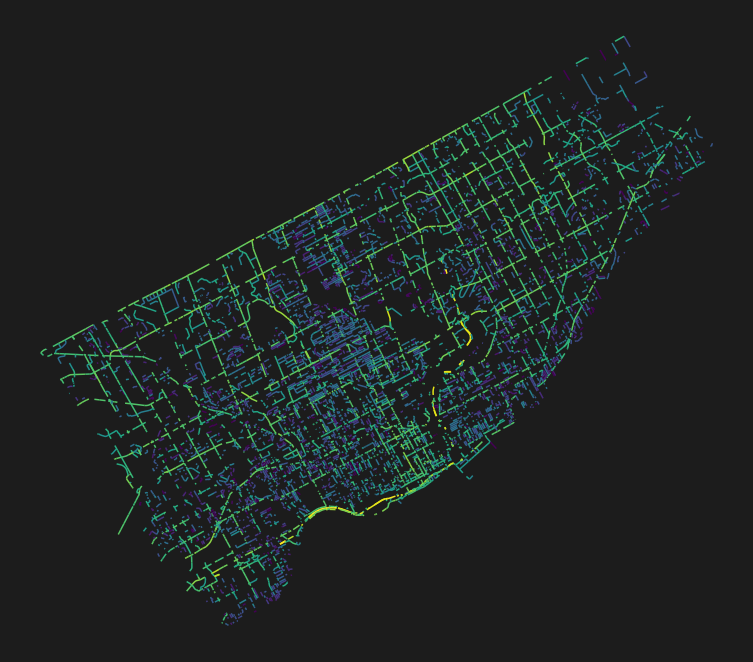

In [20]:
fig = plt.figure(figsize=(12, 9))
fig.patch.set_facecolor('#1c1c1c')
ax = fig.add_axes([0., 0., 1., 1.])
ax.axis('off')
centreline_segments.plot(
    column='AADT Estimate', ax=ax, cmap='viridis',
    norm=colors.LogNorm(), vmin=100., vmax=1e5)

[Text(0, 0.5, 'Number of Counts'), Text(0.5, 0, 'AADT')]

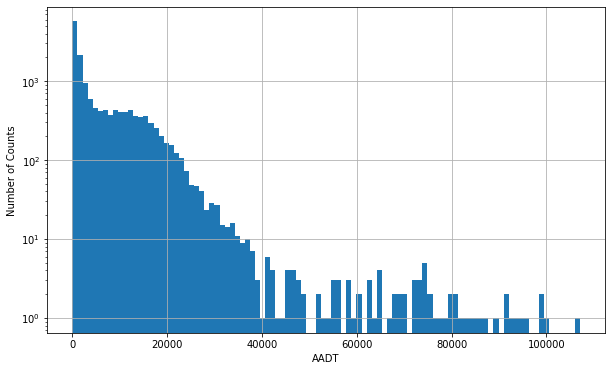

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
combined_results['AADT Estimate'].hist(
    ax=ax, bins=100, log=True)
ax.set(xlabel='AADT', ylabel='Number of Counts')

## Trace Prediction for Single STTC

Let's randomly look at 442026 and -8891 to see if the correct nearest neighbour was chosen.

In [22]:
# sorted([(k, mb.tcs.sttcs[k].data.shape[0]) for k in mb.tcs.sttcs.keys()], key=lambda x: x[1])

In [23]:
def map_neighbours(sttc):
    selected_sttc = mb.nb.data.loc[
        mb.nb.data['Centreline ID'] == sttc.centreline_id, ['Lon', 'Lat']].iloc[0, :]
    ptc_neighbours = [abs(k) for k in sttc.mpatterns.keys()]
    same_dir_ptcs = [abs(k) for k in mb.tcs.ptcs.keys() if ((k > 0) if sttc.direction > 0 else (k < 0))]

    map_TO = folium.Map(location=(43.6534, -79.3841),
                        zoom_start=12, tiles='cartodbpositron',
                        width='100%', height='100%')
    for i, row in nb.df_ptc.iterrows():
        folium.Marker([selected_sttc['Lat'], selected_sttc['Lon']], icon=folium.Icon(color='green'),
                      tooltip="{0}".format(row['Centreline ID'])).add_to(map_TO)
    for i, row in mb.nb.df_ptc.iterrows():
        if row['Centreline ID'] in same_dir_ptcs and row['Centreline ID'] not in ptc_neighbours:
            folium.Marker([row['Lat'], row['Lon']], icon=folium.Icon(color='blue'),
                          tooltip="{0}".format(row['Centreline ID'])).add_to(map_TO)
        elif row['Centreline ID'] in ptc_neighbours:
            folium.Marker([row['Lat'], row['Lon']], icon=folium.Icon(color='orange'),
                          tooltip="{0}".format(row['Centreline ID'])).add_to(map_TO)

    return map_TO

In [24]:
# First, let's have a look at the raw data.
sttc = mb.tcs.sttcs[442026]
sttc.data

,,Date,Daily Count,STTC Year,Month,Day of Week
Year,Day of Year,,,,,
2006,159,2006-06-08,336.0,2006,6,3


In [25]:
# Look at nearest neighbours.
map_neighbours(sttc)

In [26]:
# Selected nearest neighbours' order checks out.
sttc.mpatterns.keys()

dict_keys([20230203, 5849817, 438481, 6248089, 8708889])

In [27]:
# Take a look at match values for second nearest PTC.
sttc.mpatterns[5849817]['Match Values']

,,STTC Year,Closest PTC Year,DoM_ijd,D_ijd,MADT_est
Year,Day of Year,,,,,
2006,159,2006,2011,0.945183,0.882284,396.165627


In [28]:
# Check if closest year is really 2011.
mb.tcs.ptcs[5849817].perm_years

array([2011, 2012, 2013, 2014])

In [29]:
# MADT eqn.
madt_est = (sttc.data.loc[(2006, 159), 'Daily Count'] *
            mb.tcs.ptcs[5849817].ratios['DoM_ijd'].loc[(2011, 6), 3] *
            mb._average_growth_factor**(2016 - 2006))
print("MADT estimate: ", madt_est)

MADT estimate:  396.165627462599


In [30]:
# AADT eqn.
aadt_est = (sttc.data.loc[(2006, 159), 'Daily Count'] *
            mb.tcs.ptcs[5849817].ratios['D_ijd'].loc[(2011, 6), 3] *
            mb._average_growth_factor**(2016 - 2006))
print("AADT estimate: ", aadt_est)

AADT estimate:  369.8022892260083


In [31]:
print("MF_STTC", madt_est / aadt_est)

MF_STTC 1.0712903597535017


In [32]:
sttc.mpatterns[5849817]['Monthly Pattern']

,MADT_est,AADT_est,MF_STTC
Month,,,
6,396.165627,369.802289,1.07129


In [33]:
mb.get_closest_year(2016, mb.tcs.ptcs[5849817].perm_years)

2014

In [34]:
mf_ptc = (mb.tcs.ptcs[5849817].adts['MADT'].loc[2014, 'MADT'] /
          mb.tcs.ptcs[5849817].adts['AADT'].loc[2014].values[0])

In [35]:
print("MSE", ((madt_est / aadt_est) - mf_ptc[6])**2)

MSE 0.00026904364515037903


In [36]:
sttc.mses

,Count ID,MSE
0,20230203,0.000020
1,5849817,0.000269
2,438481,0.000225
3,6248089,0.000000
4,8708889,0.000000


MSE checks out.  Looks like minimum mSE will be 6248089; check that this is the case.

In [37]:
mb.tcs.ptcs[6248089].perm_years

array([2010])

In [38]:
aadt_fin_est = (sttc.data.loc[(2006, 159), 'Daily Count'] *
                mb.tcs.ptcs[6248089].ratios['D_ijd'].loc[(2010, 6), 3] *
                mb._average_growth_factor**(2016 - 2006))

In [39]:
print("Final AADT estimate", aadt_fin_est)

Final AADT estimate 341.02593976488606


In [40]:
results[0].loc[results[0]['Count ID'] == 442026, :]

,Count ID,AADT Estimate
9879,442026,341.02594


Now for the other STTC.

In [41]:
sttc = mb.tcs.sttcs[-8891]
sttc.data

Date  Daily Count  STTC Year  Month  Day of Week
Year Day of Year                                                       
2006 94          2006-04-04      20854.0       2006      4            1
     95          2006-04-05      21608.0       2006      4            2
     96          2006-04-06      22432.0       2006      4            3
2011 319         2011-11-15      20839.0       2011     11            1
     320         2011-11-16      21705.0       2011     11            2
     321         2011-11-17      22033.0       2011     11            3

In [42]:
map_neighbours(sttc)

In [43]:
# Selected nearest neighbours' order checks out.
sttc.mpatterns.keys()

dict_keys([-30073761, -8171, -13503251, -13503207, -13503206])

In [44]:
# Take a look at match values for second nearest PTC.
sttc.mpatterns[-8171]['Match Values']

STTC Year  Closest PTC Year   DoM_ijd     D_ijd  \
Year Day of Year                                                    
2006 94                2006              2012  0.898736  0.968494   
     95                2006              2012  0.935865  1.008505   
     96                2006              2012  0.858930  0.925599   
2011 319               2011              2012  1.006286  0.941007   
     320               2011              2012  1.054673  0.986255   
     321               2011              2012  0.959037  0.896823   

                      MADT_est  
Year Day of Year                
2006 94           23379.933483  
     95           25226.062066  
     96           24035.185510  
2011 319          23421.203246  
     320          25567.519220  
     321          23600.421071

In [45]:
# Check if closest year is really 2012.
mb.tcs.ptcs[-8171].perm_years

array([2012])

In [46]:
# DoM_ijd for 2011-11-16
print("DoM_ijd for (2011, 320)", mb.tcs.ptcs[-8171].ratios['DoM_ijd'].loc[(2012, 11), 2])

DoM_ijd for (2011, 320) 1.0546731624879524


In [47]:
# DoM_ijd for 2011-11-16
print("D_ijd for (2011, 320)", mb.tcs.ptcs[-8171].ratios['D_ijd'].loc[(2012, 11), 2])

D_ijd for (2011, 320) 0.986255434714204


In [48]:
# MADT for 2011-11-16
madt_est = (sttc.data.loc[(2011, 320), 'Daily Count'] *
            mb.tcs.ptcs[-8171].ratios['DoM_ijd'].loc[(2012, 11), 2] *
            mb._average_growth_factor**(2016 - 2011))
print("MADT estimate: ", madt_est)

MADT estimate:  25567.519220085072


In [49]:
# AADT for 2011
aadt_est = np.array([
    sttc.data.loc[(2006, 94), 'Daily Count'] * mb.tcs.ptcs[-8171].ratios['D_ijd'].loc[(2012, 4), 1] * mb._average_growth_factor**(2016 - 2006),
    sttc.data.loc[(2006, 95), 'Daily Count'] * mb.tcs.ptcs[-8171].ratios['D_ijd'].loc[(2012, 4), 2] * mb._average_growth_factor**(2016 - 2006),
    sttc.data.loc[(2006, 96), 'Daily Count'] * mb.tcs.ptcs[-8171].ratios['D_ijd'].loc[(2012, 4), 3] * mb._average_growth_factor**(2016 - 2006),
    sttc.data.loc[(2011, 319), 'Daily Count'] * mb.tcs.ptcs[-8171].ratios['D_ijd'].loc[(2012, 11), 1] * mb._average_growth_factor**(2016 - 2011),
    sttc.data.loc[(2011, 320), 'Daily Count'] * mb.tcs.ptcs[-8171].ratios['D_ijd'].loc[(2012, 11), 2] * mb._average_growth_factor**(2016 - 2011),
    sttc.data.loc[(2011, 321), 'Daily Count'] * mb.tcs.ptcs[-8171].ratios['D_ijd'].loc[(2012, 11), 3] * mb._average_growth_factor**(2016 - 2011)]).mean()
print("AADT estimate: ", aadt_est)

AADT estimate:  24359.948198593745


In [50]:
sttc.mpatterns[-8171]['Monthly Pattern']

,MADT_est,AADT_est,MF_STTC
Month,,,
4,24213.727020,24359.948199,0.993997
11,24196.381179,24359.948199,0.993285


In [51]:
mf_sttc = (
    sttc.mpatterns[-8171]['Monthly Pattern']['MADT_est'] / sttc.mpatterns[-8171]['Monthly Pattern']['AADT_est'])

In [52]:
# Double check MF_STTC column.
mf_sttc

Month
4     0.993997
11    0.993285
dtype: float64

In [53]:
mf_ptc = (mb.tcs.ptcs[-8171].adts['MADT'].loc[2012, 'MADT'] /
          mb.tcs.ptcs[-8171].adts['AADT'].loc[2012].values[0])

In [54]:
print("MSE", ((mf_sttc - mf_ptc)**2).mean())

MSE 0.0050741908544784916


In [55]:
sttc.mses

,Count ID,MSE
0,-30073761,0.002506
1,-8171,0.005074
2,-13503251,0.001369
3,-13503207,0.001569
4,-13503206,0.001792


In [56]:
aadt_fin_est = (sttc.data.loc[:, 'Daily Count'].values[3:] *
                sttc.mpatterns[-13503251]['Match Values']['D_ijd'].values[3:] *
                mb._average_growth_factor**(2016 - 2011)).mean()

In [57]:
aadt_fin_est

27093.584414849563

In [58]:
results[0].loc[results[0]['Count ID'] == -8891, :]

,Count ID,AADT Estimate
7352,-8891,27093.584415


In [59]:
sttc

## Widening unit tests to all STTCs and PTCs

### Checking if all PTCs have properly calculated annual averages

In [63]:
# Check that STTCs have date/time values.
for sttc in mb.tcs.sttcs.values():
    assert set(['STTC Year', 'Month', 'Day of Week']).issubset(
        set(sttc.data.columns))

In [66]:
# Check that ptcs have ratios.
for ptc in mb.tcs.ptcs.values():
    if ptc.ratios['DoM_ijd'].isnull().any(axis=None):
        assert set(['DoM_i', 'D_i', 'avail_years']).issubset(
            set(ptc.ratios.keys()))
else:
    assert not (set(['DoM_i', 'D_i', 'avail_years'])
                .intersection(set(ptc.ratios.keys())))

In [85]:
# Check that a year doesn't exist if its DoM_ijd is NaN
for ptc in mb.tcs.ptcs.values():
    if ptc.ratios['DoM_ijd'].isnull().any(axis=None):
        for (year, month), row in ptc.ratios['DoM_ijd'].iterrows():
            for dow in row.keys():
                if np.isnan(row[dow]):
                    assert year not in ptc.ratios['avail_years'].loc[month, dow]

In [105]:
# Check mean growth factor.
assert mb.average_growth_factor == np.mean([
    ptc.growth_factor for ptc in mb.tcs.ptcs.values()])

In [104]:
# Check that STTC neighbours are correct.
for sttc in mb.tcs.sttcs.values():
    neighbours = [sttc.direction * x for x in nb.get_neighbours(sttc.centreline_id)[0]]
    neighbours = [x for x in neighbours if x in mb.tcs.ptcs.keys()][:5]
    assert list(sttc.mpatterns.keys()) == neighbours

In [136]:
# Check that DoM and D_ijd was properly assigned to each STTC.
for sttc in mb.tcs.sttcs.values():
    for ptc_id in sttc.mpatterns.keys():
        ptc = mb.tcs.ptcs[ptc_id]
        for i, (_, row) in enumerate(sttc.data.iterrows()):
            closest_ptc_year = sttc.mpatterns[ptc_id]['Match Values'].iloc[i, 1]
            month = row['Month']
            dow = row['Day of Week']
            try:
                # i, 2 is DoM_ijd
                assert np.isclose(sttc.mpatterns[ptc_id]['Match Values'].iat[i, 2],
                                  ptc.ratios['DoM_ijd'].at[(closest_ptc_year, month), dow])
                # i, 3 is D_ijd
                assert np.isclose(sttc.mpatterns[ptc_id]['Match Values'].iat[i, 3],
                                  ptc.ratios['D_ijd'].at[(closest_ptc_year, month), dow])
            except:
                # If the above didn't work, we had to have used the closest year average.
                assert np.isclose(sttc.mpatterns[ptc_id]['Match Values'].iat[i, 2],
                                  ptc.ratios['DoM_i'].at[closest_ptc_year, 'DoM_i'])
                assert np.isclose(sttc.mpatterns[ptc_id]['Match Values'].iat[i, 3],
                                  ptc.ratios['D_i'].at[closest_ptc_year, 'D_i'])

In [168]:
# Check that we've calculated MADT and AADT estimates properly.
for sttc in mb.tcs.sttcs.values():
    for mpatt in sttc.mpatterns.values():
        ref_madt = (sttc.data['Daily Count'].values * 
                    mpatt['Match Values']['DoM_ijd'].values *
                    mpatt['Growth Factor']**(2016. - mpatt['Match Values']['STTC Year'].values))
        assert np.allclose(ref_madt,  mpatt['Match Values']['MADT_est'].values)

        ref_aadt = (sttc.data['Daily Count'].values * 
                    mpatt['Match Values']['D_ijd'].values *
                    mpatt['Growth Factor']**(2016. - mpatt['Match Values']['STTC Year'].values)).mean()
        assert np.isclose(ref_aadt, mpatt['Monthly Pattern']['AADT_est'].mean())
        
        ref_madt_df = sttc.data[['Month']].copy()
        ref_madt_df['MADT'] = ref_madt

        assert np.allclose(ref_madt_df.groupby('Month')['MADT'].mean() / ref_aadt,
                           mpatt['Monthly Pattern']['MF_STTC'].values)

In [185]:
# Check that we've estimated the MSE properly.
for sttc in mb.tcs.sttcs.values():
    for ptc_id in sttc.mpatterns.keys():
        ptc = mb.tcs.ptcs[ptc_id]

        closest_year = mb.get_closest_year(2016, ptc.perm_years)
        ptc_monthly_pattern = (
            ptc.adts['MADT'].loc[closest_year, 'MADT'] /
            ptc.adts['AADT'].loc[closest_year, 'AADT'])

        sttc_pattern = sttc.mpatterns[ptc_id]['Monthly Pattern']['MF_STTC']
        ptc_monthly_pattern_select = ptc_monthly_pattern.loc[sttc_pattern.index]

        mse_ref = ((sttc_pattern - ptc_monthly_pattern_select)**2).mean()

        assert np.isclose(mse_ref, sttc.mses.loc[sttc.mses['Count ID'] == ptc_id, 'MSE'].values[0])

In [233]:
# Check that we can extract the right AADT from the MSE.
for sttc in mb.tcs.sttcs.values():
    mmse_count = sttc.mses.loc[sttc.mses['MSE'].idxmin(), 'Count ID']
    ptc_years = sttc.mpatterns[mmse_count]['Match Values'].index.levels[0].values
    closest_year = mb.get_closest_year(2016, ptc_years)
    aadt_ref = (sttc.data.loc[closest_year]['Daily Count'].values *
     sttc.mpatterns[mmse_count]['Match Values'].loc[closest_year, 'D_ijd'].values *
     sttc.mpatterns[mmse_count]['Growth Factor'] ** (2016 - closest_year)).mean()

    aadt = results[0].loc[results[0]['Count ID'] == sttc.count_id, 'AADT Estimate'].values[0]

    assert np.isclose(aadt_ref, aadt)

In [234]:
# Ditto, but for PTCs.
for ptc in mb.tcs.ptcs.values():
    closest_year = mb.get_closest_year(2016, ptc.perm_years)
    aadt_est_ref = (
        ptc.adts['AADT'].loc[closest_year, 'AADT'] *
        mb.average_growth_factor**(2016 - closest_year))
    
    aadt = results[1].loc[results[1]['Count ID'] == ptc.count_id, 'AADT Estimate'].values[0]

    np.isclose(aadt_est_ref, aadt)               

In [252]:
# Check that we've estimated the MSE properly for Bagheri.
for sttc in mbb.tcs.sttcs.values():
    closest_ptc_id = list(sttc.mpatterns.keys())[0]
    for ptc_id in sttc.mpatterns.keys():
        ptc = mbb.tcs.ptcs[ptc_id]

        closest_year = mbb.get_closest_year(2016, ptc.perm_years)
        ptc_monthly_pattern = (
            ptc.adts['MADT'].loc[closest_year, 'MADT'] /
            ptc.adts['AADT'].loc[closest_year, 'AADT'])

        sttc_pattern = sttc.mpatterns[closest_ptc_id]['Monthly Pattern']['MF_STTC']
        ptc_monthly_pattern_select = ptc_monthly_pattern.loc[sttc_pattern.index]

        mse_ref = ((sttc_pattern - ptc_monthly_pattern_select)**2).mean()

        assert np.isclose(mse_ref, sttc.mses.loc[sttc.mses['Count ID'] == ptc_id, 'MSE'].values[0])

In [254]:
# Check that we can extract the right AADT from the MSE for Bagheri.
for sttc in mbb.tcs.sttcs.values():
    mmse_count = sttc.mses.loc[sttc.mses['MSE'].idxmin(), 'Count ID']
    ptc_years = sttc.mpatterns[mmse_count]['Match Values'].index.levels[0].values
    closest_year = mb.get_closest_year(2016, ptc_years)
    aadt_ref = (sttc.data.loc[closest_year]['Daily Count'].values *
     sttc.mpatterns[mmse_count]['Match Values'].loc[closest_year, 'D_ijd'].values *
     sttc.mpatterns[mmse_count]['Growth Factor'] ** (2016 - closest_year)).mean()

    aadt = results_bag[0].loc[results[0]['Count ID'] == sttc.count_id, 'AADT Estimate'].values[0]

    assert np.isclose(aadt_ref, aadt)